# Apple's Stock Price Prediction based on Weather Forecasts

> Code in the style of https://www.relataly.com/stock-market-prediction-using-multivariate-time-series-in-python/1815/

## Imports & Setup

In [1]:
import tensorflow as tf # tensorflow==2.2.0
import keras # Keras==2.4.3
import keras2onnx #keras2onnx==1.7.0
import numpy as np #'1.18.5'
from datasets import Dataset, Features, Value, DatasetDict
import datetime
import jaydebeapi as jdbc
import pandas as pd
from trino.dbapi import connect
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
from math import ceil
from sklearn.preprocessing import RobustScaler, MinMaxScaler

In [2]:
assert np.__version__ == '1.18.5'
assert tf.__version__ == '2.2.0'
assert keras.__version__ == '2.4.3'
assert keras2onnx.__version__ == '1.7.0'

## Get training data via Trino

In [17]:
df_structure = {
    'Date': Value(dtype='timestamp[ns]', id=None),
    'Close': Value(dtype='float32', id=None),
    'Avg Wind Speed': Value(dtype='float32', id=None),
    'Precipitation': Value(dtype='float32', id=None),
    'Snow': Value(dtype='float32', id=None), 
    'Snow Depth': Value(dtype='float32', id=None),
    'Temp AVG': Value(dtype='float32', id=None),
    'Temp Max': Value(dtype='float32', id=None),
    'Temp Min': Value(dtype='float32', id=None) 
}
df_structure.keys()

dict_keys(['Date', 'Close', 'Avg Wind Speed', 'Precipitation', 'Snow', 'Snow Depth', 'Temp AVG', 'Temp Max', 'Temp Min'])

In [19]:
with connect(
    host="127.0.0.1",
    port=8080,
    user="anybody",
    catalog="mongodb",
    schema="weather",
) as join:
    link = join.cursor()
    link.execute("SELECT a.Date, a.Close, w.AWND, w.PRCP, w.SNOW, w.SNWD, w.TAVG, w.TMAX, w.TMIN \
            FROM mongodb.weather.weatherny w JOIN trinodemo.public.applehistory a \
            ON w._id = a.Date WHERE a.Date < date \'2022-09-01\' ORDER BY date ASC")
    both = pd.DataFrame(link.fetchall())
both.columns = df_structure.keys()
both.index = pd.to_datetime(both['Date'], format='%Y-%m-%d')
#both.index = pd.DatetimeIndex(both['Date']).to_period('B')
both.drop('Date', inplace=True, axis=1)
both.replace('NaN', 0, inplace=True)
for col in both.columns:
    both[col] = both[col].astype(np.float32)
min(both.index)

Timestamp('2012-08-10 00:00:00')

### Plot Data

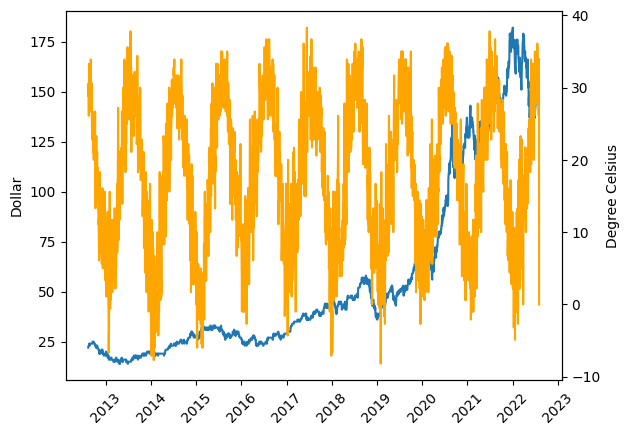

In [21]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(both.index, both['Close']) #to_timestamp()
ax.set_ylabel('Dollar')
ax2 = ax.twinx()
ax2.plot(both.index, both['Temp Max'], color='orange') #to_timestamp()
ax2.set_ylabel('Degree Celsius')
ax.tick_params(axis='x', labelrotation=45)
plt.show()

In [22]:
corr = both.corr()
corr = pd.DataFrame(corr).style.background_gradient(cmap='coolwarm')
corr

,Close,Avg Wind Speed,Precipitation,Snow,Snow Depth,Temp AVG,Temp Max,Temp Min
Close,1.000000,-0.006186,0.017374,-0.013364,-0.012153,0.081831,0.028463,0.030106
Avg Wind Speed,-0.006186,1.000000,0.147193,0.189433,0.079917,-0.309082,-0.371176,-0.372611
Precipitation,0.017374,0.147193,1.000000,0.142457,0.008007,0.029516,0.014935,0.035367
Snow,-0.013364,0.189433,0.142457,1.000000,0.282824,-0.171642,-0.189905,-0.189385
Snow Depth,-0.012153,0.079917,0.008007,0.282824,1.000000,-0.276810,-0.289819,-0.296096
Temp AVG,0.081831,-0.309082,0.029516,-0.171642,-0.276810,1.000000,0.930075,0.926662
Temp Max,0.028463,-0.371176,0.014935,-0.189905,-0.289819,0.930075,1.000000,0.962658
Temp Min,0.030106,-0.372611,0.035367,-0.189385,-0.296096,0.926662,0.962658,1.000000


## Preprocess Training Data

In [50]:
np_data_unscaled = np.array(both)
print(np_data_unscaled.shape)

scaler = MinMaxScaler().fit(np_data_unscaled)
np_data_scaled = scaler.transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
df_y = pd.DataFrame(both['Close'])
scaler_pred = MinMaxScaler().fit(df_y)
np_Close_scaled = scaler_pred.transform(df_y)

both_scaled = pd.DataFrame(np_data_scaled, columns=list(df_structure.keys())[1:])

(2512, 8)


In [23]:
hf_dataset = Dataset.from_pandas(both, features=Features(df_structure))
hf_dataset = hf_dataset.train_test_split(test_size=0.2, shuffle=False)
hf_dataset.data

{'train': InMemoryTable
 Date: timestamp[ns]
 Close: float
 Avg Wind Speed: float
 Precipitation: float
 Snow: float
 Snow Depth: float
 Temp AVG: float
 Temp Max: float
 Temp Min: float
 ----
 Date: [[2012-08-10 00:00:00.000000000,2012-08-13 00:00:00.000000000,2012-08-14 00:00:00.000000000,2012-08-15 00:00:00.000000000,2012-08-16 00:00:00.000000000,...,2020-07-30 00:00:00.000000000,2020-07-31 00:00:00.000000000,2020-08-03 00:00:00.000000000,2020-08-04 00:00:00.000000000,2020-08-05 00:00:00.000000000]]
 Close: [[22,23,23,23,23,...,96,106,109,110,110]]
 Avg Wind Speed: [[4,4,3.1,3,3.4,...,3.1,2.5,4.6,7.2,3.7]]
 Precipitation: [[7.9,0,1.3,15.7,0,...,0.3,14.2,8.9,11.4,0]]
 Snow: [[0,0,0,0,0,...,0,0,0,0,0]]
 Snow Depth: [[0,0,0,0,0,...,0,0,0,0,0]]
 Temp AVG: [[0,0,0,0,0,...,30.6,25.6,30.1,25.9,28]]
 Temp Max: [[28.9,30.6,27.8,26.1,30,...,35.6,28.9,33.9,28.3,32.2]]
 Temp Min: [[22.2,22.2,23.9,21.1,21.1,...,26.7,22.2,23.3,22.8,25]],
 'test': InMemoryTable
 Date: timestamp[ns]
 Close: float
 

In [53]:
hf_dataset['train'].__getitem__(range(3))

{'Date': [Timestamp('2012-08-10 00:00:00'),
  Timestamp('2012-08-13 00:00:00'),
  Timestamp('2012-08-14 00:00:00')],
 'Close': [22.0, 23.0, 23.0],
 'Avg Wind Speed': [4.0, 4.0, 3.0999999046325684],
 'Precipitation': [7.900000095367432, 0.0, 1.2999999523162842],
 'Snow': [0.0, 0.0, 0.0],
 'Snow Depth': [0.0, 0.0, 0.0],
 'Temp AVG': [0.0, 0.0, 0.0],
 'Temp Max': [28.899999618530273, 30.600000381469727, 27.799999237060547],
 'Temp Min': [22.200000762939453, 22.200000762939453, 23.899999618530273]}

## Partition Dataset into Sequences

In [36]:
sequence_length = 10
train_len = ceil(len(both) * 0.85)
index_y = both.columns.get_loc("Close")

train_data = np_data_scaled[0:train_len, :]
test_data = np_data_scaled[train_len - sequence_length:, :]

def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_y]) #contains the prediction values for validation,  for single-step prediction
    
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_y] == y_train[0])

(2126, 10, 8) (2126,)
(376, 10, 8) (376,)
True


## Define Model & Start Training

In [12]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(6))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

80 10 8


2022-09-14 15:29:43.744177: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-09-14 15:29:43.781403: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f7a42855100 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-09-14 15:29:43.781422: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


In [13]:
y_train = np.asarray(y_train).astype('float32')
x_train = np.asarray(x_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')
x_test = np.asarray(x_test).astype('float32')

epochs = 40
batch_size = 16
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test)
                   )
model.save('applepricepredict.h5', save_format='h5')

Epoch 1/40
50/50 [==============================] - 1s 26ms/step - loss: 0.0130 - val_loss: 0.0019
Epoch 2/40
50/50 [==============================] - 1s 12ms/step - loss: 6.3133e-04 - val_loss: 0.0022
Epoch 3/40
50/50 [==============================] - 1s 10ms/step - loss: 6.2616e-04 - val_loss: 0.0021
Epoch 4/40
50/50 [==============================] - 1s 11ms/step - loss: 5.5497e-04 - val_loss: 0.0021
Epoch 5/40
50/50 [==============================] - 1s 11ms/step - loss: 6.2385e-04 - val_loss: 0.0020
Epoch 6/40
50/50 [==============================] - 1s 11ms/step - loss: 5.5567e-04 - val_loss: 0.0021
Epoch 7/40
50/50 [==============================] - 1s 11ms/step - loss: 8.8721e-04 - val_loss: 0.0031
Epoch 8/40
50/50 [==============================] - 1s 11ms/step - loss: 6.9100e-04 - val_loss: 0.0023
Epoch 9/40
50/50 [==============================] - 1s 11ms/step - loss: 5.1360e-04 - val_loss: 0.0021
Epoch 10/40
50/50 [==============================] - 1s 11ms/step - loss: 5.2

### Plot Model Performance

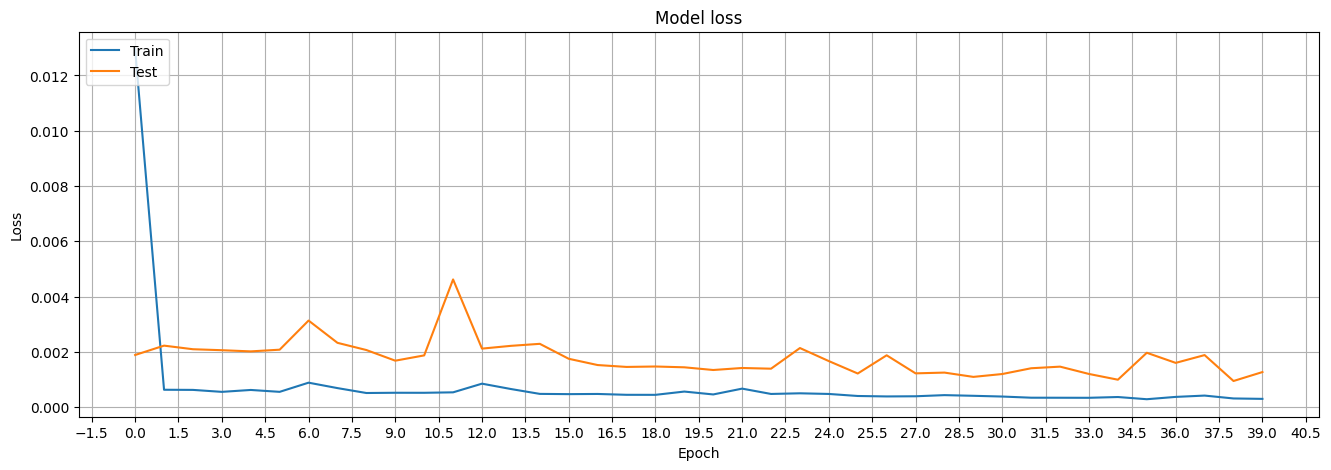

In [14]:
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
sns.lineplot(data=history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

### Convert model format

In [9]:
import tf2onnx.convert

model = keras.models.load_model('applepricepredict.h5')

spec = (tf.TensorSpec((None, 10, 8), tf.float32, name="input"),)
model_proto, _ = tf2onnx.convert.from_keras(
    model, 
    input_signature=spec, 
    opset=13, 
    output_path='applepricepredict.onnx'
)
output_names = [n.name for n in model_proto.graph.output]

Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


## Model validation

In [12]:
import onnxruntime as ort

x_test = x_test.astype(np.float32)
providers = ['CPUExecutionProvider']
m = ort.InferenceSession('applepricepredict.onnx', providers=providers)
onnx_pred = m.run(None, {"input": x_test})

print('ONNX Shape:', onnx_pred[0].shape, '1st Predicted:', onnx_pred[0][0])

ONNX Shape: (202, 1) 1st Predicted: [0.717738]


In [13]:
from sklearn.metrics import mean_absolute_error
y_pred_scaled = onnx_pred[0]

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Median Absolute Error (MAE): 4.199999809265137
Mean Absolute Percentage Error (MAPE): 2.62 %
Median Absolute Percentage Error (MDAPE): 2.43 %


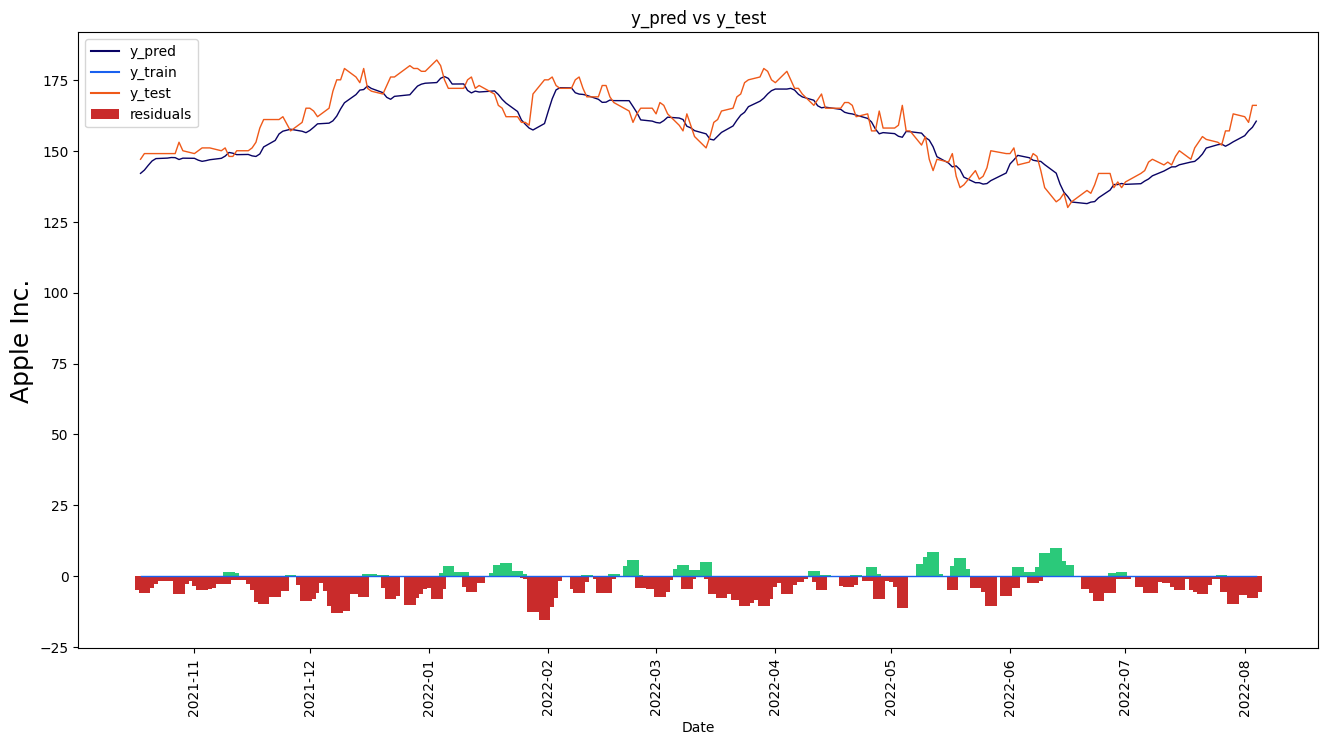

In [14]:
# The date from which on the date is displayed
display_start_date = '2021-10-15'

# Add the difference between the valid and predicted prices
train = pd.DataFrame(both['Close'][:train_data_len + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(both['Close'][train_data_len:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])
df_union = df_union.fillna(0)
df_union.index = df_union.index.to_timestamp()

# Zoom in to a closer timeframe
df_union_zoom = df_union[df_union.index > display_start_date]

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_pred vs y_test")
plt.ylabel('Apple Inc.', fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)
plt.xticks(rotation=90)

# Create the bar plot with the differences
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.show()

## Run Inference

### Get weather & stock prices between end of train/test period and now

In [15]:
with connect(
    host="127.0.0.1",
    port=8080,
    user="anybody",
    catalog="kafka",
    schema="default",
) as join:
    link = join.cursor()
    link.execute("SELECT DISTINCT a.date, a.apple_price, w.AWND, w.PRCP, \
            w.SNOW, w.SNWD, w.TAVG, w.TMAX, w.TMIN FROM trinoweather w LEFT OUTER JOIN trinostock a \
            ON w.DATE = a.date WHERE a.date > date \'2022-08-04\' ORDER BY date ASC")
    data2predict = pd.DataFrame(link.fetchall())
data2predict.columns = ['Date', 'Close', 'Avg Wind Speed', 'Precipitation', \
                        'Snow', 'Snow Depth', 'Temp AVG', 'Temp Max', 'Temp Min']
data2predict.index = pd.to_datetime(data2predict['Date'], format='%Y-%m-%d')
data2predict.index = pd.DatetimeIndex(data2predict['Date']).to_period('B')
data2predict.drop('Date', inplace=True, axis=1)
data2predict.dropna(inplace=True)
data2predict = data2predict[-10:]
data2predict

,Close,Avg Wind Speed,Precipitation,Snow,Snow Depth,Temp AVG,Temp Max,Temp Min
Date,,,,,,,,
2022-08-31,157.22,5.2,0.0,0.0,0.0,26.1,31.1,22.2
2022-09-01,157.96,5.7,0.0,0.0,0.0,26.3,31.7,20.6
2022-09-02,155.81,3.3,0.0,0.0,0.0,22.0,25.0,16.7
2022-09-06,154.53,4.3,22.1,0.0,0.0,22.8,23.9,19.4
2022-09-07,155.96,5.7,0.0,0.0,0.0,20.6,23.9,18.9
2022-09-08,154.46,3.3,0.0,0.0,0.0,21.9,26.7,18.3
2022-09-09,157.37,3.2,0.0,0.0,0.0,20.7,26.1,15.6
2022-09-12,163.43,3.4,1.5,0.0,0.0,22.4,26.1,20.0
2022-09-13,153.84,5.1,0.3,0.0,0.0,24.7,31.1,20.6


### Get weather from now on

In [16]:
with connect(
    host="127.0.0.1",
    port=8080,
    user="anybody",
    catalog="kafka",
    schema="default",
) as join:
    link = join.cursor()
    link.execute("SELECT DISTINCT date, AWND, PRCP, SNOW, SNWD, TAVG, TMAX, TMIN FROM trinoweather \
            WHERE date > date \'2022-09-13\' ORDER BY date ASC")
    data2predict2 = pd.DataFrame(link.fetchall())
data2predict2.columns = ['Date', 'Avg Wind Speed', 'Precipitation', \
                        'Snow', 'Snow Depth', 'Temp AVG', 'Temp Max', 'Temp Min']
data2predict2.index = pd.to_datetime(data2predict2['Date'], format='%Y-%m-%d')
data2predict2.index = pd.DatetimeIndex(data2predict2['Date']).to_period('B')
data2predict2.drop('Date', inplace=True, axis=1)
data2predict2.dropna(inplace=True)
data2predict2.insert(0, 'Close', 0)
data2predict2

,Close,Avg Wind Speed,Precipitation,Snow,Snow Depth,Temp AVG,Temp Max,Temp Min
Date,,,,,,,,
2022-09-14,0,5.5,0.00,0.0,0.0,23.3,28.9,18.3
2022-09-20,0,17.0,0.01,0.0,0.0,17.0,40.0,23.0
2022-09-21,0,16.5,0.64,0.0,0.0,16.5,21.0,12.0
2022-09-22,0,15.5,1.17,0.0,0.0,15.5,19.0,10.0
2022-09-23,0,18.0,0.66,0.0,0.0,18.0,22.0,9.0
2022-09-26,0,7.0,0.00,0.0,0.0,7.0,33.0,13.0
2022-09-26,0,24.5,0.00,0.0,0.0,24.5,23.0,14.0
2022-09-26,0,7.0,0.00,0.0,0.0,7.0,22.0,7.0
2022-09-27,0,19.5,0.00,0.0,0.0,19.5,28.0,11.0


In [17]:
df2predict = pd.concat([data2predict, data2predict2])
nrows = len(data2predict)+1

### Merge model predictions into dataframe to iteratively predict future stock prices

In [19]:
predicitons = []
for i in range(nrows, len(df2predict)):
    
    np_data_unscaled = np.array(df2predict[i-nrows:i-1])
    #np_data = np.reshape(np_data_unscaled, (nrows-1, -1))
    np_data_scaled = np.array([scaler.transform(np_data_unscaled)])
    
    onnx_pred = m.run(None, {"input": np_data_scaled.astype('float32')})
    y_pred_scaled = onnx_pred[0]

    # Unscale the predicted values
    y_pred = scaler_pred.inverse_transform(y_pred_scaled)[0]
    predicitons.append(y_pred)
    df2predict.iloc[i-1,0] = y_pred
df2predict

,Close,Avg Wind Speed,Precipitation,Snow,Snow Depth,Temp AVG,Temp Max,Temp Min
Date,,,,,,,,
2022-08-31,157.220000,5.2,0.00,0.0,0.0,26.1,31.1,22.2
2022-09-01,157.960000,5.7,0.00,0.0,0.0,26.3,31.7,20.6
2022-09-02,155.810000,3.3,0.00,0.0,0.0,22.0,25.0,16.7
2022-09-06,154.530000,4.3,22.10,0.0,0.0,22.8,23.9,19.4
2022-09-07,155.960000,5.7,0.00,0.0,0.0,20.6,23.9,18.9
2022-09-08,154.460000,3.3,0.00,0.0,0.0,21.9,26.7,18.3
2022-09-09,157.370000,3.2,0.00,0.0,0.0,20.7,26.1,15.6
2022-09-12,163.430000,3.4,1.50,0.0,0.0,22.4,26.1,20.0
2022-09-13,153.840000,5.1,0.30,0.0,0.0,24.7,31.1,20.6


In [20]:
prediction = pd.DataFrame({'predicted': df2predict['Close']})
prediction.index = pd.Series(df2predict.index)
prediction.head()

,predicted
Date,
2022-08-31,157.22
2022-09-01,157.96
2022-09-02,155.81
2022-09-06,154.53
2022-09-07,155.96


<AxesSubplot:xlabel='Date'>

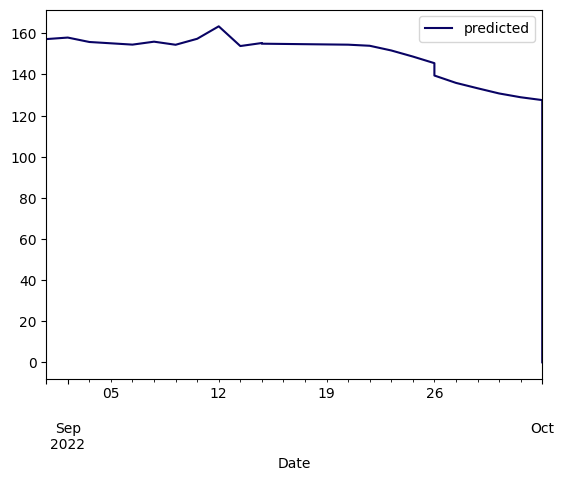

In [21]:
prediction.plot()